# <center> XGboost model </center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import *
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import *
import multiprocessing as mp
mp.set_start_method('forkserver')
sns.set()
%matplotlib inline

In [2]:
## load data from data.npz
def load_data():
    X_train = pd.read_pickle("./X_train.pkl")
    X_test  = pd.read_pickle("./X_test.pkl")
    with np.load('data.npz', allow_pickle=True) as npz_file:
        y_train_cla=pd.Series(npz_file['y_train_cla'] , name='book_rating_class')
        y_train_reg=pd.Series(npz_file['y_train_reg'] , name='book_rating_count_log')
        authors_df_train=pd.DataFrame(npz_file['authors_df_train'] , columns=npz_file['authors_to_keep'])
        genres_df_train=pd.DataFrame(npz_file['genres_df_train'] , columns=npz_file['genres_to_keep'])
        format_df_train=pd.DataFrame(npz_file['format_df_train'] , columns=npz_file['formats_to_keep'])
        title_df_train=pd.DataFrame(npz_file['title_df_train'] , columns=npz_file['title_columns'])
        desc_df_train=pd.DataFrame(npz_file['desc_df_train'] , columns=npz_file['desc_columns'])
        image_df_train=pd.DataFrame(npz_file['image_df_train'] , columns=npz_file['image_columns'])
        y_test_cla=pd.Series(npz_file['y_test_cla'] , name='book_rating_class')
        y_test_reg=pd.Series(npz_file['y_test_reg'] , name='book_rating_count_log')
        authors_df_test=pd.DataFrame(npz_file['authors_df_test'] , columns=npz_file['authors_to_keep'])
        genres_df_test=pd.DataFrame(npz_file['genres_df_test'] , columns=npz_file['genres_to_keep'])
        format_df_test=pd.DataFrame(npz_file['format_df_test'] , columns=npz_file['formats_to_keep'])
        title_df_test=pd.DataFrame(npz_file['title_df_test'] , columns=npz_file['title_columns'])
        desc_df_test=pd.DataFrame(npz_file['desc_df_test'] , columns=npz_file['desc_columns'])
        image_df_test=pd.DataFrame(npz_file['image_df_test'] , columns=npz_file['image_columns']) 
        authors_to_keep=npz_file['authors_to_keep']
        genres_to_keep=npz_file['genres_to_keep']
        formats_to_keep=npz_file['formats_to_keep']
        title_columns=npz_file['title_columns']
        desc_columns=npz_file['desc_columns']
        image_columns=npz_file['image_columns']
    return X_train,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, image_df_train, X_test,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, image_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns
    #return X_train,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, X_test,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns
X_train_base,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, image_df_train, X_test_base,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, image_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns = load_data()
#X_train_base,y_train_cla,y_train_reg, authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train, X_test_base,y_test_cla,y_test_reg, authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test, authors_to_keep, genres_to_keep, formats_to_keep, title_columns,desc_columns,image_columns = load_data()
X_train = pd.concat((X_train_base.book_pages_log,authors_df_train, genres_df_train, format_df_train, title_df_train, desc_df_train), axis=1)
X_test = pd.concat((X_test_base.book_pages_log,authors_df_test, genres_df_test, format_df_test, title_df_test, desc_df_test), axis=1)
print(X_train.shape, X_test.shape)

(32234, 2325) (8059, 2325)


We will train our xgboost model with a grid of parameters :

In [3]:
y_train_cla_1h = LabelBinarizer().fit_transform(y_train_cla.values.reshape(-1, 1))
y_test_cla_1h = LabelBinarizer().fit_transform(y_test_cla.values.reshape(-1, 1))
#dtrain = xgb.DMatrix(data=X_train.head(100), label=y_train_cla.head(100))
#dtest = xgb.DMatrix(data=X_test.head(100))
dtrain = xgb.DMatrix(data=X_train, label=y_train_cla)
dtest = xgb.DMatrix(data=X_test)

params = {
    'learning_rate': np.array([0.01,0.001]),
    'subsample': np.array([0.7,0.8,0.9]),
    'max_depth': np.array([10,11,12,13,14,15,16,17]),
    'lambda': np.array([1]),
    'gamma': np.array([0]),
    'nthread': [16],
    'objective': ['multi:softprob'], 
    'num_class': [4]
}
def fit_xgb(params, y_train_cla, y_train_cla_1h, y_test_cla, y_test_cla_1h):
    model = xgb.train(params, dtrain) 
    pred = model.predict(dtest)
    tr_pred = model.predict(dtrain)
    s1 = roc_auc_score(y_train_cla_1h, tr_pred)
    s2 = accuracy_score(y_train_cla, np.argmax(tr_pred,axis=1))
    #print ('train : auc score :%s, accuracy score :%s'%(s1,s2))
    s1_t = roc_auc_score(y_test_cla_1h, pred)
    s2_t = accuracy_score(y_test_cla, np.argmax(pred,axis=1))
    #print ('test : auc score :%s, accuracy score :%s'%(s1_t,s2_t))
    return (params, s2, s1, s2_t, s1_t), pred
def grid_xgb(params):
    results =[]
    preds=[]
    for param in ParameterGrid(params):
        #res, pred = fit_xgb(param, y_train_cla.head(100), y_train_cla_1h[:100], y_test_cla.head(100), y_test_cla_1h[:100])
        res, pred =  fit_xgb(param, y_train_cla, y_train_cla_1h, y_test_cla, y_test_cla_1h)
        results += [res]
        preds += [pred]
    return results, preds

In [4]:
results, preds =  grid_xgb(params)

The following table shows results for each hyperparameter grid combination :

In [5]:
df = pd.DataFrame(results, columns=['params', 'train_accuracy','train_auc','test_accuracy', 'test_auc'])
df

,params,train_accuracy,train_auc,test_accuracy,test_auc
0,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.780821,0.935099,0.428465,0.689275
1,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.785692,0.937528,0.424122,0.689317
2,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.781194,0.935619,0.424618,0.691006
3,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.839517,0.960353,0.428465,0.690851
4,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.846032,0.963506,0.429706,0.692154
5,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.844016,0.962410,0.423378,0.691500
6,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.886114,0.976637,0.425487,0.691774
7,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.891047,0.978275,0.430823,0.693884
8,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.892288,0.979090,0.431443,0.692147
9,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.917727,0.985673,0.434173,0.690007


The best hyperparameter values and performance is :

In [6]:
df[df.test_accuracy == df.test_accuracy.max()]

,params,train_accuracy,train_auc,test_accuracy,test_auc
16,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.963517,0.996257,0.443603,0.697136


The performance of this model (44%) is better than the default one used in notebook 03 (41%). Bit is lower than the neural network one (48%).

We will show the confusion matrix and classification report for this model :

In [7]:
cm = confusion_matrix(y_test_cla, np.argmax(preds[df[df.test_accuracy == df.test_accuracy.max()].index[0]],axis=1))
cm

array([[1061,  394,  294,  226],
       [ 673,  633,  427,  321],
       [ 364,  416,  762,  524],
       [ 201,  269,  375, 1119]])

In [8]:
classes = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test_cla, np.argmax(preds[df[df.test_accuracy == df.test_accuracy.max()].index[0]],axis=1), target_names=classes))

              precision    recall  f1-score   support

     class 0       0.46      0.54      0.50      1975
     class 1       0.37      0.31      0.34      2054
     class 2       0.41      0.37      0.39      2066
     class 3       0.51      0.57      0.54      1964

   micro avg       0.44      0.44      0.44      8059
   macro avg       0.44      0.45      0.44      8059
weighted avg       0.44      0.44      0.44      8059



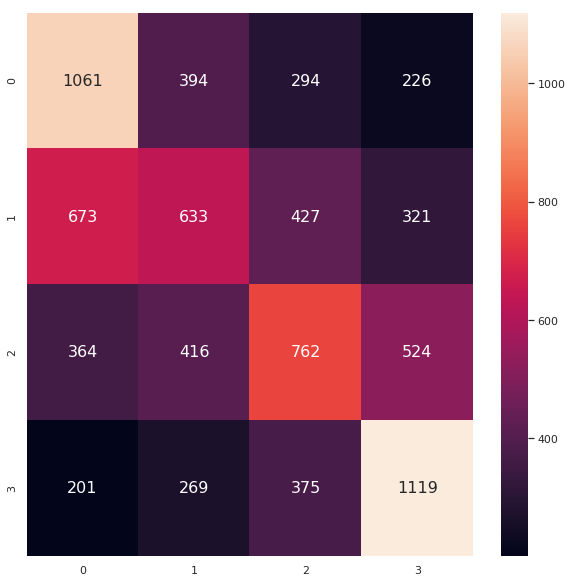

In [9]:
plt.figure(figsize=(10,10))
df_cm = pd.DataFrame(cm, np.arange(4), np.arange(4))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') ;

Finally, we will train an xgboost model with the image features only :

In [10]:
dtrain = xgb.DMatrix(data=image_df_train, label=y_train_cla)
dtest = xgb.DMatrix(data=image_df_test)
results_img, preds_img =  grid_xgb(params)
df_img = pd.DataFrame(results_img, columns=['params', 'train_accuracy','train_auc','test_accuracy', 'test_auc'])
df_img

,params,train_accuracy,train_auc,test_accuracy,test_auc
0,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.798970,0.943698,0.270381,0.524535
1,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.809828,0.948359,0.274352,0.526770
2,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.833499,0.959354,0.270877,0.526278
3,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.855091,0.966502,0.271250,0.521581
4,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.864956,0.970241,0.274848,0.526190
5,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.891016,0.979511,0.268520,0.524357
6,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.897220,0.980330,0.271374,0.523330
7,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.908389,0.983760,0.279315,0.525920
8,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.930911,0.990314,0.270133,0.526693
9,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.931005,0.989191,0.269140,0.525261


In [11]:
df_img.to_pickle("df_img.pkl")

In [12]:
df_img[df_img.test_accuracy == df_img.test_accuracy.max()]

,params,train_accuracy,train_auc,test_accuracy,test_auc
46,"{'gamma': 0, 'lambda': 1, 'learning_rate': 0.0...",0.987312,0.999207,0.2813,0.532873


As we can see, the performance of the best model (28%) is about the same as baseline (25%).

The image features does not contains helpfull information to classify our data.